# Energy Measurements

The goal of this experiment is to measure energy consumed while running some workload on Juno R2 board using the collected kernel traces. It will be necessary to collect the following events:

 - `cpu_frequency`, to understand at what frequency each CPU is running
 - `sched_switch`, to filter out intervals of time in which the CPU is idle

In [1]:
import logging
reload(logging)
log_fmt = '%(asctime)-9s %(levelname)-8s: %(message)s'
logging.basicConfig(format=log_fmt)

# Change to info once the notebook runs ok
logging.getLogger().setLevel(logging.DEBUG)

In [25]:
%pylab inline

import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## OPPs

In order to measure energy the user needs to provide all OPPs available in the target device. In our case, we are using a Juno R2 as target device which has the following OPPs:

In [77]:
juno_opps = {
    # LITTLE cluster
    'little' : {
        # Frequency (kHz) : Voltage (mV)
        450000 : 820,
        800000 : 900,
        950000 : 1000,
    },
    # big cluster
    'big' : {
        600000  : 820,
        1000000 : 900,
        1200000 : 1000,
    }
}

# Target Configuration

Our target is a Juno R2 development board running Linux.

In [4]:
# Setup a target configuration
my_target_conf = {
    
    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    
    # Target board IP/MAC address
    "host"        : '10.1.205.160',
    
    # Login credentials
    "username"    : 'root',
    "password"    : '',
    
    # RTApp calibration values (comment to let LISA do a calibration run)
    "rtapp-calib" :  {
        "0": 318, "1": 125, "2": 124, "3": 318, "4": 318, "5": 319
    },
    
    # Tools required by the experiments
    "tools"   : [ 'rt-app', 'trace-cmd' ],    
    "exclude_modules" : ['hwmon'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_switch",
         ],
         "buffsize" : 10 * 1024,
    },
}

# Tests execution

In [5]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
te = TestEnv(target_conf=my_target_conf)
target = te.target

2016-04-04 15:46:01,558 INFO    :         Target - Using base path: /home/micgio01/work/lisa
2016-04-04 15:46:01,559 INFO    :         Target - Loading custom (inline) target configuration
2016-04-04 15:46:01,560 DEBUG   :         Target - Target configuration {'username': 'root', 'platform': 'linux', 'host': '10.1.205.160', 'ftrace': {'buffsize': 10240, 'events': ['cpu_frequency', 'sched_switch']}, 'board': 'juno', 'rtapp-calib': {'1': 125, '0': 318, '3': 318, '2': 124, '5': 319, '4': 318}, 'exclude_modules': ['hwmon'], 'password': '', 'tools': ['rt-app', 'trace-cmd']}
2016-04-04 15:46:01,561 INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
2016-04-04 15:46:01,562 INFO    :         Target - Connecting linux target:
2016-04-04 15:46:01,562 INFO    :         Target -   username : root
2016-04-04 15:46:01,563 INFO    :         Target -       host : 10.1.205.160
2016-04-04 15:46:01,564 INFO    :         Target -   password : 
2016-04-04 15:46:01,564 DEBUG   :         T

# Change `cpufreq` governor

Setting the target `cpufreq` governor to `ondemand` so that frequency changes when the load changes.

In [6]:
target.cpufreq.set_all_governors('ondemand');

2016-04-04 15:46:20,053 DEBUG   : sudo -- sh -c '/root/devlib-target/bin/shutils cpufreq_set_all_governors ondemand'


# Workloads configuration

In [16]:
# Create a new RTApp workload generator
rtapp = RTA(target, 'nrg_wload', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        'task_ramp_5': Ramp(
            period_ms=200,         # period
            start_pct=10,          # initial_load
            delta_pct=5,           # load % increase...
            time_s=1               # ... every 1[s]
        ).get(),
        
        'task_ramp_10': Ramp(
            period_ms=200,
            start_pct=10,
            delta_pct=10,
            time_s=1
        ).get()
    },
    
    run_dir=target.working_directory
    
);

2016-04-04 15:50:00,200 INFO    :          WlGen - Setup new workload nrg_wload
2016-04-04 15:50:00,201 DEBUG   :          WlGen - Setup step [postrun] callback to [__postrun] function
2016-04-04 15:50:00,201 DEBUG   :          WlGen - Configuring a profile-based workload...
2016-04-04 15:50:00,202 DEBUG   :          RTApp - ref on big cpu: 1
2016-04-04 15:50:00,202 INFO    :          RTApp - Workload duration defined by longest task
2016-04-04 15:50:00,203 INFO    :          RTApp - Default policy: SCHED_OTHER
2016-04-04 15:50:00,203 INFO    :          RTApp - ------------------------
2016-04-04 15:50:00,203 INFO    :          RTApp - task [task_ramp_10], sched: using default policy
2016-04-04 15:50:00,204 INFO    :          RTApp -  | calibration CPU: 1
2016-04-04 15:50:00,204 INFO    :          RTApp -  | loops count: 1
2016-04-04 15:50:00,204 INFO    :          RTApp - + phase_000001: duration 1.000000 [s] (5 loops)
2016-04-04 15:50:00,205 INFO    :          RTApp - |  period   200

# Workload execution

In [17]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

2016-04-04 15:50:01,200 INFO    : #### Setup FTrace
2016-04-04 15:50:01,302 DEBUG   : sudo -- sh -c 'echo 10240 > '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
2016-04-04 15:50:01,541 DEBUG   : sudo -- sh -c 'cat '\''/sys/kernel/debug/tracing/buffer_size_kb'\'''
2016-04-04 15:50:01,973 DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd reset'
2016-04-04 15:50:03,146 DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd start -e cpu_frequency -e sched_switch'
2016-04-04 15:50:04,317 DEBUG   : sudo -- sh -c 'echo TRACE_MARKER_START > '\''/sys/kernel/debug/tracing/trace_marker'\'''
2016-04-04 15:50:04,443 DEBUG   : Trace CPUFreq frequencies
2016-04-04 15:50:04,545 DEBUG   : sudo -- sh -c '/root/devlib-target/bin/shutils cpufreq_trace_all_frequencies'
2016-04-04 15:50:04,892 INFO    : #### Start RTApp execution
2016-04-04 15:50:04,893 INFO    :          WlGen - Workload execution START:
2016-04-04 15:50:04,894 INFO    :          WlGen -    /root/devlib-target/bin/rt-app /r

# Trace Analysis

In [18]:
# Collect the trace
trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)
# Parse trace
nrg_trace = trappy.FTrace(trace_file)

2016-04-04 15:50:26,114 INFO    : #### Save FTrace: /home/micgio01/work/lisa/results/20160404_154619/trace.dat
2016-04-04 15:50:26,216 DEBUG   : sudo -- sh -c '/root/devlib-target/bin/trace-cmd extract -o /root/devlib-target/trace.dat'
2016-04-04 15:50:27,718 DEBUG   : /usr/bin/scp -r   root@10.1.205.160:/root/devlib-target/trace.dat /home/micgio01/work/lisa/results/20160404_154619/trace.dat


We can plot a timing diagram of the tasks running on each CPU with:

In [19]:
trappy.plotter.plot_trace(nrg_trace)

# Energy Calculation

In [20]:
cpu0_freqs = nrg_trace.cpu_frequency.data_frame[nrg_trace.cpu_frequency.data_frame['cpu'] == 0]

In [21]:
cpu0_freqs

,__comm,__cpu,__pid,cpu,frequency
Time,,,,,
0.000000,shutils,2,1247,0,450000
1.944862,kworker/0:1,0,853,0,800000
5.544796,kworker/0:1,0,853,0,950000
7.248834,kworker/0:1,0,853,0,450000
7.947276,kworker/0:1,0,853,0,950000
13.065396,kworker/0:1,0,853,0,450000
20.564057,shutils,2,1266,0,450000


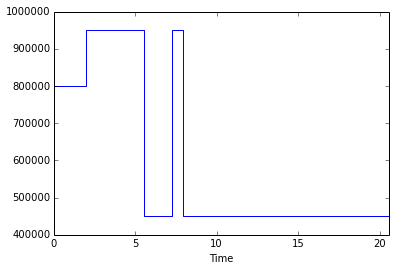

In [22]:
cpu0_freqs['frequency'].plot(drawstyle='steps');

In [23]:
cpu0_tasks = nrg_trace.sched_switch.data_frame[nrg_trace.sched_switch.data_frame['__cpu'] == 0]

In [129]:
cpu0_tasks.head()

,__comm,__cpu,__pid,next_comm,next_pid,next_prio,prev_comm,prev_pid,prev_prio,prev_state
Time,,,,,,,,,,
0.417728,<idle>,0,0,rt-app,1251,120,swapper/0,0,120,0
0.527610,task_ramp_5,0,1251,swapper/0,0,120,task_ramp_5,1251,120,1
0.617912,<idle>,0,0,task_ramp_5,1251,120,swapper/0,0,120,0
0.728050,task_ramp_5,0,1251,swapper/0,0,120,task_ramp_5,1251,120,1
0.818062,<idle>,0,0,task_ramp_5,1251,120,swapper/0,0,120,0


In [36]:
idle_tasks = cpu0_tasks[cpu0_tasks['__pid'] == 0]
# sched_switch events where next task is the IDLE task
next_idle_tasks = cpu0_tasks[cpu0_tasks['next_pid'] == 0]

In [56]:
# Compute intervals of time in which CPU0 is not IDLE
tasks_time_intervals = pd.DataFrame(columns=['start', 'end', 'time_interval'])
i = 0
for t1, t2 in zip(idle_tasks.index, next_idle_tasks.index):
    tasks_time_intervals.loc[i] = [t1, t2, t2 - t1]
    i += 1

In [78]:
# Compute the non-IDLE time spent at a certain frequency
time_at_freq = pd.DataFrame(columns=['time', 'frequency', 'voltage'])
i = 0
row_iterator = cpu0_freqs.iterrows()
t_prev, f_prev = row_iterator.next()  # take first item from row_iterator
for t, f in row_iterator:
    nonidle_time = tasks_time_intervals[(tasks_time_intervals['start'] >= t_prev) & (tasks_time_intervals['start'] <= t)]
    freq = f['frequency']
    time_at_freq.loc[i] = [nonidle_time.sum()['time_interval'], freq, juno_opps['little'][freq]]
    i += 1
    f_prev = f
    t_prev = t

# We can sum the time intervals with same frequncy and voltage
time_at_freq = time_at_freq.groupby(['frequency', 'voltage']).sum()
# Index by voltage
time_at_freq = time_at_freq.reset_index('frequency')

Let's assume our load capacitance ($C_L$) is 500 $fF$

In [124]:
C_L = 500*(10**(-15))

In [131]:
energy = 0.0
for v in time_at_freq.index:
    energy += (v/1000.0)**2 * (time_at_freq.loc[v]['frequency']*1000.0) * time_at_freq.loc[v]['time']

print "Energy = {} mJ".format(energy*C_L*1000)

Energy = 2.44968847407 mJ


In [134]:
power = 0.0
for v in time_at_freq.index:
    power += (v/1000.0)**2 * (time_at_freq.loc[v]['frequency']*1000.0)
    
print "Power is {} mW".format(power*C_L*1000)

Power is 0.95029 mW
